OrsaEvent @ 123.456
  Multiplicity: 42
  NPE: 100.0 +5.0 -5.0
  Energy: 2.5 +0.1 -0.1
  Position (x,y,z): UncertainValue{Float64}[1.0 +0.1 -0.1, 2.0 +0.2 -0.2, 3.0 +0.1 -0.1]



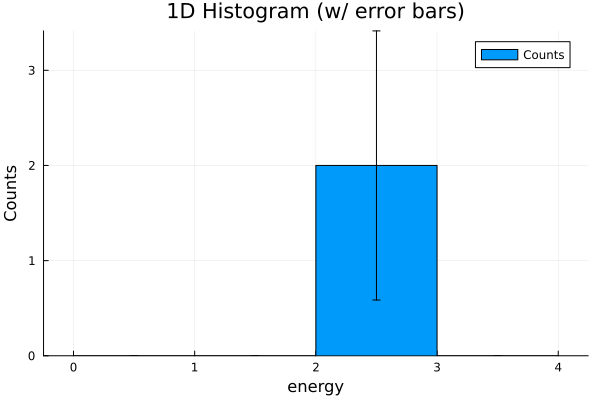

In [21]:
using OrsaFitter
using OrsaFitter.Types
using OrsaFitter.EventModule
using OrsaFitter.HistogramModule
using Plots

# Create uncertain values
x = UncertainValue(1.0, 0.1)
y = UncertainValue(2.0, 0.2)
z = UncertainValue(3.0, 0.1)
npe = UncertainValue(100.0, 5.0)
energy = UncertainValue(2.5, 0.1)

# Create one event
evt = Event_from_cartesian(123.456, x, y, z, 42, npe, energy)

# Print and plot
println(evt)
plot_event_position(evt)

# Create a 1D histogram in energy
edges = ([0.0, 1.0, 2.0, 3.0, 4.0],)  # tuple with one vector
h = HistogramND(edges, [:energy])

fill_histogram!(h, [evt, evt])

# Plot histogram
plot_histogram(h, with_errorbars = true)


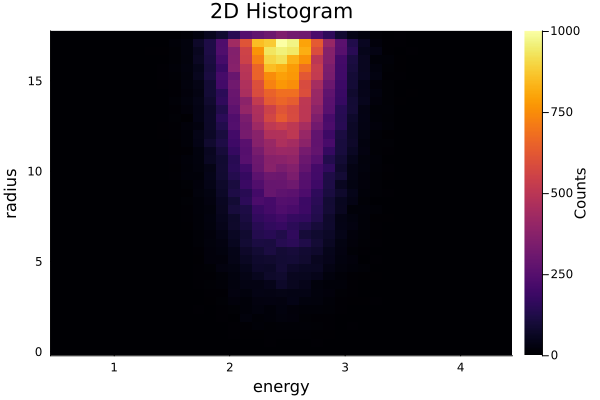

In [2]:
using OrsaFitter
using OrsaFitter.Types
using OrsaFitter.EventModule
using OrsaFitter.HistogramModule
using StaticArrays
using Random
using Distributions
using Plots

# Set seed for reproducibility
Random.seed!(1234)

# Simulation parameters
N = 100_000
radius = 17.7
μ_E = 2.5
σ_E = 0.3
gauss_energy = Normal(μ_E, σ_E)

# Create events
events = OrsaEvent[]
for _ in 1:N
    # Uniform position in sphere
    u = rand()
    costheta = rand(-1.0:0.0001:1.0)
    theta = acos(costheta)
    phi = rand() * 2π
    r = radius * u^(1/3)

    x_val = r * sin(theta) * cos(phi)
    y_val = r * sin(theta) * sin(phi)
    z_val = r * cos(theta)

    x = UncertainValue(x_val, 0.0)
    y = UncertainValue(y_val, 0.0)
    z = UncertainValue(z_val, 0.0)

    # Energy from Gaussian
    e_val = rand(gauss_energy)
    energy = UncertainValue(e_val, 0.1)

    npe = UncertainValue(100.0, 5.0)  # dummy

    push!(events, Event_from_cartesian(0.0, x, y, z, 1, npe, energy))
end

# Wrap in EventCollection
collection = OrsaEventCollection(events, CPU())

# Create 2D histogram: Energy vs Radius
edges_energy = range(0.5, 4.5; length=40) |> collect
edges_radius = range(0.0, 18.0; length=40) |> collect
h2d = HistogramND((edges_energy, edges_radius), [:energy, :radius])

# to_histogram(events, )
fill_histogram!(h2d, collection)

# # Show plot
plot_histogram(h2d)


--- Generating 1e+06 Events ---


  1.542097 seconds (20.00 M allocations: 1.311 GiB, 40.14% gc time, 1.02% compilation time)


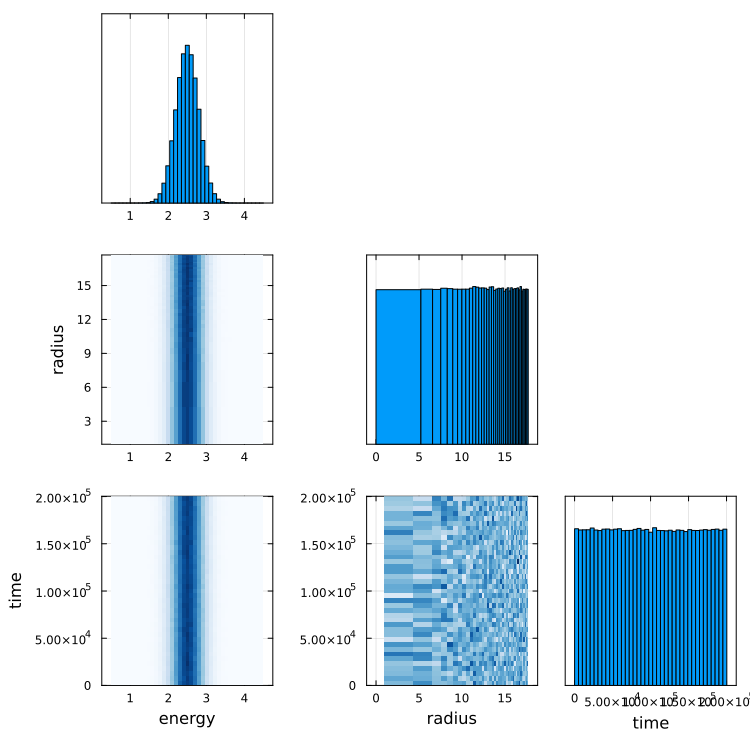

In [3]:
using OrsaFitter
using OrsaFitter.Types
using OrsaFitter.EventModule
using OrsaFitter.HistogramModule
using Random
using Distributions
using StaticArrays
using Plots
using Printf

# Seed for reproducibility
Random.seed!(123)

# Simulation settings
N = 1_000_000
radius = 17.7
μ_E, σ_E = 2.5, 0.3
gauss_E = Normal(μ_E, σ_E)

println("--- Generating $(@sprintf "%.0e" N) Events ---")

const σ_energy = 0.1
const σ_npe = 5.0
const npe_val = 100.0
const reco_mult = 1

tau = 1 / 5  # 5 Hz
exp_dist = Exponential(tau)

# Cumulative sum of N exponential samples
timestamps = cumsum(rand(exp_dist, N))


σ0 = UncertainValue(0.0, 0.0)  # cached to reuse
σ_npe_val = UncertainValue(npe_val, σ_npe)

events = @time begin
    local_events = Vector{OrsaEvent{Float64}}(undef, N)
    @inbounds for i in 1:N
        u = rand()
        θ = acos(rand(-1.0:0.0001:1.0))
        ϕ = rand() * 2π
        r = radius * cbrt(u)

        sinθ = sin(θ)
        x = r * sinθ * cos(ϕ)
        y = r * sinθ * sin(ϕ)
        z = r * cos(θ)

        E = rand(gauss_E)
        ts = timestamps[i]

        local_events[i] = Event_from_cartesian(
            ts,
            UncertainValue(x, 0.0),
            UncertainValue(y, 0.0),
            UncertainValue(z, 0.0),
            reco_mult,
            σ_npe_val,
            UncertainValue(E, σ_energy),
        )
    end
    local_events
end


# Define bins
edges_energy = collect(range(0.5, 4.5; length=40))
edges_radius = cbrt.(range(0.0, radius^3; length=40))
edges_time = range(0.0, stop=maximum(timestamps), length=40)

# Fill 3D histogram
h3d = to_histogram(events;
                   dims=[:energy, :radius, :time],
                   edges=(edges_energy, edges_radius, collect(edges_time)),
                   threaded=true)

# Plot corner
plot_corner(h3d)

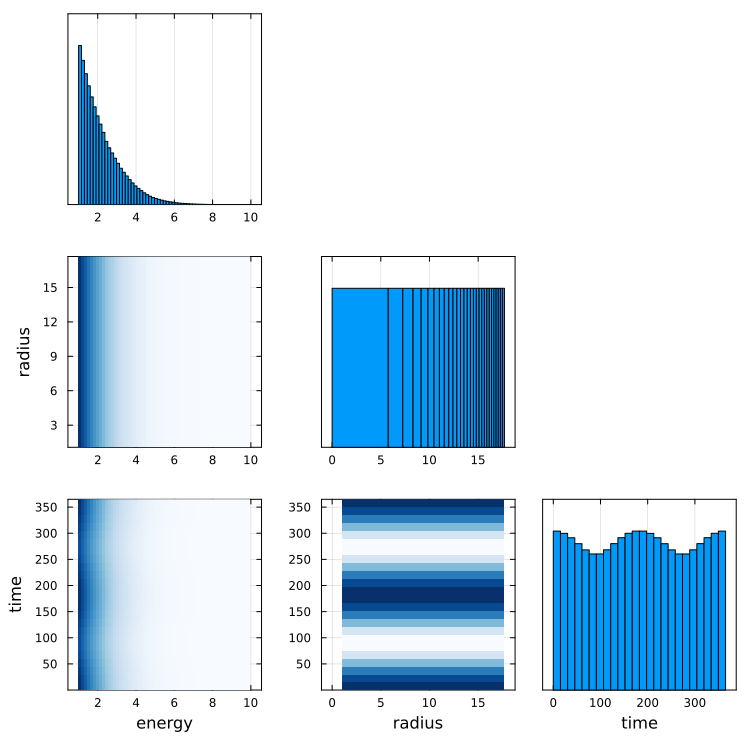

In [8]:
using OrsaFitter
using OrsaFitter.Types
using OrsaFitter.HistogramModule
using OrsaFitter.SpectrumModule
using OrsaFitter.ReactorModule
using Plots

# --- Define output histogram structure ---
E_edges = collect(range(1.0, 10.0; length=60))            # MeV
R_edges = collect(cbrt.(range(0.0, 17.7^3; length=30)))   # radius in m (uniform in volume)
# R_edges = collect(range(0.0, 17.7; length=30))   # radius in m (uniform in volume)
T_edges = collect(range(0.0, 365.0; length=25))           # days

output_dims = [:energy, :radius, :time]
output_edges = (E_edges, R_edges, T_edges)

# --- Define time-evolving fission fractions using Pair syntax ---
times = (T_edges[1:end-1] .+ T_edges[2:end]) ./ 2
ff_time_evolving = [
    t => Dict(
        "U235" => 0.57 - 0.57*sin(2π * t / 365)^2,
        "U238" => 0.08 - 0.08*sin((2π * t + π) / 365)^2,
        "Pu239" => 0.30 + 0.3sin(2π * t / 365)^2,
        "Pu241" => 0.05 + 0.05*sin((2π * t + π) / 365)^2,
    ) for t in times
]

# --- Optionally: define a radius profile (uniform if omitted) ---
# n_rbins = length(R_edges) - 1
# radius_profile = ones(n_rbins)  # flat weight per bin

# --- Construct generator ---
g = ReactorSpectrumGenerator(
    model = "HM",
    fission_fractions = ff_time_evolving,
    thermal_power = 2.9,         # GW
    distance = 52.5e3,           # meters
    radius_profile = nothing, #radius_profile,
    time_profile = nothing,      # uses fission fractions instead
    output_dims = output_dims,
    output_edges = output_edges,
    # output_type = :pdf,
    output_type = :histogram,
    integration_method= :center
)

# --- Generate the spectrum (histogram) ---
pdf = OrsaFitter.ReactorModule.get_pdf(g)

# --- Plot corner plot ---
plot_corner(pdf)

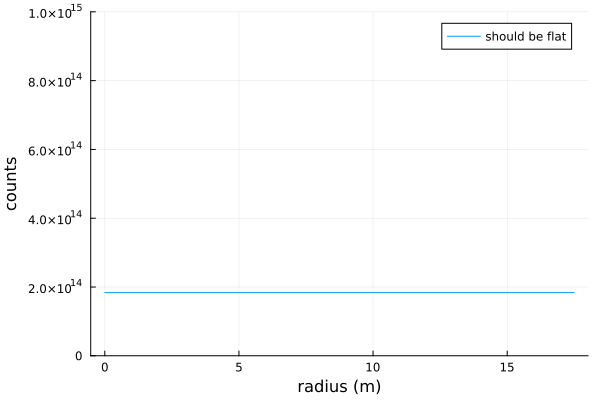

In [19]:
using OrsaFitter.HistogramModule
r_hist = contract(pdf, [:energy, :time])
# r_hist = project(pdf, [:radius])
plot(r_hist.edges[1][1:end-1], r_hist.counts, xlabel="radius (m)", ylabel="counts", label="should be flat")
ylims!(0, 1e15)

In [ ]:
# using OrsaFitter
# using OrsaFitter.Types
# using OrsaFitter.HistogramModule
# using OrsaFitter.SpectrumModule
# using OrsaFitter.ReactorModule
# using Plots

# # --- Define output histogram structure ---
# E_edges = collect(range(1.0, 10.0; length=60))            # MeV
# R_edges = collect(cbrt.(range(0.0, 17.7^3; length=30)))   # radius in m (uniform in volume)
# # R_edges = collect(range(0.0, 17.7; length=30))   # radius in m (uniform in volume)
# T_edges = collect(range(0.0, 365.0; length=25))           # days

# output_dims = [:energy]
# output_edges = (E_edges)

# ff = Dict(
#         "U235" => 0.57,
#         "U238" => 0.08,
#         "Pu239" => 0.30,
#         "Pu241" => 0.05,
#     )

# # --- Optionally: define a radius profile (uniform if omitted) ---
# # n_rbins = length(R_edges) - 1
# # radius_profile = ones(n_rbins)  # flat weight per bin

# # --- Construct generator ---
# g = ReactorSpectrumGenerator(
#     model = "HM",
#     fission_fractions = ff,
#     thermal_power = 2.9,         # GW
#     distance = 52.5e3,           # meters
#     radius_profile = nothing, #radius_profile,
#     time_profile = nothing,      # uses fission fractions instead
#     output_dims = output_dims,
#     output_edges = output_edges
# )

# # --- Generate the spectrum (histogram) ---
# pdf = OrsaFitter.ReactorModule.get_pdf(g)

# # --- Plot corner plot ---
# plot_histogram(to_pdf(pdf))

LoadError: MethodError: [0mCannot `convert` an object of type [92mVector{Float64}[39m[0m to an object of type [91mNTuple{60, Vector{Float64}}[39m
The function `convert` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  (::Type{T})(::Any) where T<:Tuple
[0m[90m   @[39m [90mBase[39m [90m[4mtuple.jl:455[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T<:Tuple
[0m[90m   @[39m [90mBase[39m [90m[4messentials.jl:600[24m[39m
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:126[24m[39m
[0m  ...


Dict{String, Float64} with 4 entries:
  "Pu239" => 0.305111
  "Pu241" => 0.0509668
  "U238"  => 0.0784531
  "U235"  => 0.560289

In [ ]:
pdf

HistogramND{Float64, 3}(([1.0, 1.152542372881356, 1.305084745762712, 1.4576271186440677, 1.6101694915254237, 1.7627118644067796, 1.9152542372881356, 2.0677966101694913, 2.2203389830508473, 2.3728813559322033  …  8.627118644067796, 8.779661016949152, 8.932203389830509, 9.084745762711865, 9.23728813559322, 9.389830508474576, 9.542372881355933, 9.694915254237289, 9.847457627118644, 10.0], [0.0, 5.761124585856717, 7.258562136787761, 8.308979458439296, 9.145215228108809, 9.851384467622733, 10.468658122831773, 11.020634868121979, 11.522249171713433, 11.983622053627156  …  15.638098067247507, 15.894505903063767, 16.142897678376247, 16.38387197652894, 16.617958916878592, 16.845630481099292, 17.067308935205563, 17.28337375757015, 17.49416738301425, 17.7], [0.0, 15.208333333333334, 30.416666666666668, 45.625, 60.833333333333336, 76.04166666666667, 91.25, 106.45833333333333, 121.66666666666667, 136.875  …  228.125, 243.33333333333334, 258.5416666666667, 273.75, 288.9583333333333, 304.166666666666

In [ ]:
pdf = OrsaFitter.ReactorModule.get_pdf(g)

HistogramND{Float64, 3}(([1.0, 1.152542372881356, 1.305084745762712, 1.4576271186440677, 1.6101694915254237, 1.7627118644067796, 1.9152542372881356, 2.0677966101694913, 2.2203389830508473, 2.3728813559322033  …  8.627118644067796, 8.779661016949152, 8.932203389830509, 9.084745762711865, 9.23728813559322, 9.389830508474576, 9.542372881355933, 9.694915254237289, 9.847457627118644, 10.0], [0.0, 5.761124585856717, 7.258562136787761, 8.308979458439296, 9.145215228108809, 9.851384467622733, 10.468658122831773, 11.020634868121979, 11.522249171713433, 11.983622053627156  …  15.638098067247507, 15.894505903063767, 16.142897678376247, 16.38387197652894, 16.617958916878592, 16.845630481099292, 17.067308935205563, 17.28337375757015, 17.49416738301425, 17.7], [0.0, 15.208333333333334, 30.416666666666668, 45.625, 60.833333333333336, 76.04166666666667, 91.25, 106.45833333333333, 121.66666666666667, 136.875  …  228.125, 243.33333333333334, 258.5416666666667, 273.75, 288.9583333333333, 304.166666666666